# Testing Signal Reconstruction (Part II)

Starting a new notebook to test changes to functionality in Part I notebook.

Here we will look at:

#### Signal Scaling

We have a number of options. We need scaling because:
* The maximum residual = 2\*max and the minimal residual = 2\*min. This will be 2x regardless of the length as we are only subtracting two values.
* The "unit length" eigenvalue is unit length in the zero mean, -1 to 1 space. This is actually sqrt(2) for 2D space, is sqrt(3) for 3D space and will be generally sqrt(L) where L is the segment length. We will also have both +ve and -ve values - so range is -sqrt(L) to sqrt(L).
    * So we could divide our output by the unit length to get in -1 to 1.
    
#### Ternary Signal Reconstruction

When we generate the signal:
* We subtract the mean - **m** from the signal_max.
* We compare +ve values with 0 to (signal_max-**m**).
* We take the absolute of -ve values and compare with 0 to **m**.
* Zeroes we just keep as zeros.

To reconstruct:
* We need to sum +ve and -ve values separately.
* We then reconstruct as m + (signal_max-m) x average(+ve values) - m x average(-ve values).

For the residuals:
* We have min residual = -2, max residual = 2 and zero mean. 
* For reconstruction we thus have 0 + (2) x average(+ve values) - (-2) x average(-ve values) > 2 x average of all values.

For reconstruction, one issue is that we may have [-1, 1] as a prediction. Is this a positive or negative value?

If we make our signal symmetrical about the mean then (signal_max - m) = m, i.e. signal_max = 2m and so we have m\*positive average + m\*negative values = m\*(av_positive - av_negative) = m * average, which is why our m + m\*average works for 128.

So we want to clamp symmetrically about the mean as pre-processing.

If we don't scale our forward output (r) is in the range +/- L/sqrt(L). Our backward output will have maximum outputs that sum to unit length. If we scale r by multiplying by sqrt(L)/L we have output in the range +/- 1. So we need to scale our backward r by L/sqrt(L). We then need to apply PBT to both to threshold into range -1, 0, 1.

## Improved VPU

We can update our VPU function by dividing r by the unit length (sqrt(L)) as this is equal to multiplying the transformation by 1/sqrt. This can form part of r processing. 

What is the output range for the transformation.

In [1]:
import numpy as np

np.random.uniform()

0.029331821001911895

In [2]:
for i in range(1,20):
    print(f"sqrt({i})/{i}: {np.sqrt(i)/i} \t - {i}/sqrt({i}) - {i/np.sqrt(i)}")

sqrt(1)/1: 1.0 	 - 1/sqrt(1) - 1.0
sqrt(2)/2: 0.7071067811865476 	 - 2/sqrt(2) - 1.414213562373095
sqrt(3)/3: 0.5773502691896257 	 - 3/sqrt(3) - 1.7320508075688774
sqrt(4)/4: 0.5 	 - 4/sqrt(4) - 2.0
sqrt(5)/5: 0.447213595499958 	 - 5/sqrt(5) - 2.23606797749979
sqrt(6)/6: 0.40824829046386296 	 - 6/sqrt(6) - 2.4494897427831783
sqrt(7)/7: 0.37796447300922725 	 - 7/sqrt(7) - 2.6457513110645903
sqrt(8)/8: 0.3535533905932738 	 - 8/sqrt(8) - 2.82842712474619
sqrt(9)/9: 0.3333333333333333 	 - 9/sqrt(9) - 3.0
sqrt(10)/10: 0.31622776601683794 	 - 10/sqrt(10) - 3.162277660168379
sqrt(11)/11: 0.30151134457776363 	 - 11/sqrt(11) - 3.3166247903554
sqrt(12)/12: 0.28867513459481287 	 - 12/sqrt(12) - 3.464101615137755
sqrt(13)/13: 0.2773500981126146 	 - 13/sqrt(13) - 3.6055512754639896
sqrt(14)/14: 0.2672612419124244 	 - 14/sqrt(14) - 3.7416573867739413
sqrt(15)/15: 0.25819888974716115 	 - 15/sqrt(15) - 3.8729833462074166
sqrt(16)/16: 0.25 	 - 16/sqrt(16) - 4.0
sqrt(17)/17: 0.24253562503633297 	 - 17/s

In [3]:
from src.var_processor.vpu import VPU
from src.tests.vpu_wrapper import VPUWrapper, signal_pre_processor

class VPU_v2(VPU):
    """Let's update our functions modularly."""
    
    def __init__(self, size):
        """Adapted Init."""
        super(VPU_v2, self).__init__(size)
        # Calculate scale factor here to save time later
        self.scale_forward = np.sqrt(self.size)/self.size
        self.scale_backward = self.size/np.sqrt(self.size)
    
    def r_forward_processing(self, r_forward):
        """Scale r to -1 to 1 and PBT."""
        # Scale to ternary
        scaled_r = r_forward*self.scale_forward
        sign = np.sign(scaled_r)
        rand_val = np.random.uniform()
        binary_values = np.where(np.abs(scaled_r) > rand_val, 1, 0)
        # resign and convert to 8-bit
        binary_values = sign*binary_values.astype(np.uint8)
        return binary_values
    
    def r_backward_processing(self, r_backward):
        """Rescale r to -L/sqrt(L) to L/sqrt(L) and PBT."""
        # Scale to ternary
        scaled_r = r_backward*self.scale_backward
        return scaled_r
        
    def pred_input_processing(self, pred_inputs):
        """Apply PBT to get outputs in range -1, 0, 1."""
        sign = np.sign(pred_inputs)
        rand_val = np.random.uniform()
        binary_values = np.where(np.abs(pred_inputs) > rand_val, 1, 0)
        # resign and convert to 8-bit
        binary_values = sign*binary_values.astype(np.uint8)
        return binary_values
        

In [4]:
"""Use the VPU Wrapper to test advanced function."""
# Initialise two VPUs and wrappers
data_in = np.random.randint(255, size=(2, 1))
mean = np.asarray([128, 128]).reshape(-1, 1)
vpu_1 = VPU_v2(2)
vpu_2 = VPU_v2(2)
wrapper_1 = VPUWrapper(vpu_1)
wrapper_2 = VPUWrapper(vpu_2)
for _ in range(0, 1000):
    # First VPU
    ternary_input = signal_pre_processor(data_in, mean)
    _, _, residual = wrapper_1.iterate(ternary_input)
    # Second VPU
    _ = wrapper_2.iterate(residual)
est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)
print(data_in, est)
# assert np.allclose(data_in, est, rtol=0.10, atol=10)

[[ 57]
 [180]] [[ 62.208]
 [155.136]]


These are much more out than before. But sometimes okay. Lower values have higher estimates.

I wonder what happens if we add another layer...

In [5]:
wrapper_1.pred_buffer

array([[ 1.,  0.,  0., ...,  0., -1., -1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [6]:
wrapper_1.r_buffer

array([[ 1., -0.,  0., -0., -0.,  1.,  1.,  1.,  0., -0.,  1.,  0., -0.,
         1.,  1.,  0.,  1., -0., -0.,  0., -1.,  0., -1.,  0.,  0.,  1.,
         0.,  0.,  0., -0.,  1.,  0.,  0.,  1., -0.,  0.,  0., -0., -0.,
         1., -1.,  1., -1., -0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -0.,
        -1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
         0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,
         1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  1.,  1.,  0.,  0.,  1., -0.,  0.,  0., -0.,  1., -0.,  1.,
        -0.,  0.,  0., -0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0., -1., -1.,  0.,  0., -0.,  0., -0.

In [7]:
positives = np.where(wrapper_1.pred_buffer > 0)
positives

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([  0,   5,   6,   7,  25,  39,  49, 153, 168, 178, 200, 201, 226,
        235, 253, 269, 274, 287, 303, 305, 316, 321, 343, 357, 360, 364,
        372, 381, 382, 395, 402, 438, 471, 498, 508, 519, 532, 539, 545,
        550, 562, 572, 577, 582, 599, 605, 641, 691, 711, 716, 727, 740,
        748, 757, 771, 780, 811, 862, 902,   0,   5,   6,   7,  10,  13,
         14,  16,  25,  30,  33,  39,  41,  49,  53, 

In [8]:
wrapper_1.pred_buffer.shape

(2, 1000)

In [9]:
# Look at error sum
sum_err = np.zeros(shape=(2,100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(2, 1))
    mean = np.asarray([128, 128]).reshape(-1, 1)
    vpu_1 = VPU_v2(2)
    vpu_2 = VPU_v2(2)
    wrapper_1 = VPUWrapper(vpu_1)
    wrapper_2 = VPUWrapper(vpu_2)
    for _ in range(0, 1000):
        # First VPU
        ternary_input = signal_pre_processor(data_in, mean)
        _, _, residual = wrapper_1.iterate(ternary_input)
        # Second VPU
        _ = wrapper_2.iterate(residual)
    est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)
    sum_err[:, i] = (data_in - est).flatten()

In [10]:
sum_err.mean(axis=1)

array([4.78624, 1.24128])

In [11]:
# We can't use mean as have mix of +ve and -ve - if we take the MSE
MSE = np.abs(sum_err).mean(axis=1); MSE

array([23.63504, 33.88016])

In [12]:
np.abs(sum_err)

array([[  1.36 ,  73.568,  15.776,  17.136,   2.576,   1.288,  26.664,
          1.336,  24.48 ,  10.336,  20.296,   6.544,  15.368, 111.824,
         19.84 ,   7.144,  25.056,   9.632,  42.72 ,  18.648,   6.552,
          2.008,   3.568,  47.488,   2.576, 123.488,  10.264,   5.048,
          5.72 ,  28.496,  13.192,   2.056,  21.288,  18.624,  11.528,
          7.816,   4.864,  10.608,   7.696,  16.504,   8.152,  42.064,
         10.768,  13.136,   7.8  ,   5.2  ,  11.456,  24.248,   6.224,
         22.432,   4.392,  26.744,  14.832,  11.44 ,   3.528,  21.472,
         29.136,  35.112,  28.824,  31.696,   1.832,  21.368,  94.92 ,
         41.864,  26.736,  22.008,   2.808,   7.8  ,  21.904,  46.912,
         12.848,   0.944,  39.848,  37.336,   9.184,  14.744,  14.192,
          3.024, 123.744,   9.304,  12.952,  46.232,  16.696,   9.768,
          7.048,  23.872,   9.104,  31.024,  15.136,  16.44 ,  24.08 ,
          7.536,  10.224,   1.384, 120.568,  13.056, 106.68 , 123.104,
      

In [13]:
np.sqrt((sum_err**2).mean(axis=1))

array([36.83245781, 51.28756587])

In [14]:
data_in - est

array([[ 28.944],
       [-11.08 ]])

In [15]:
vpu_1.__dict__

{'cu': <src.var_processor.covariance.CovarianceUnit at 0x7f4983c609b0>,
 'pi': <src.var_processor.power_iterator.PowerIterator at 0x7f4983c60518>,
 'size': 2,
 'scale_forward': 0.7071067811865476,
 'scale_backward': 1.414213562373095}

In [16]:
# Try three VPUs
sum_err = np.zeros(shape=(2,100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(2, 1))
    mean = np.asarray([128, 128]).reshape(-1, 1)
    vpu_1 = VPU_v2(2)
    vpu_2 = VPU_v2(2)
    vpu_3 = VPU_v2(2)
    wrapper_1 = VPUWrapper(vpu_1)
    wrapper_2 = VPUWrapper(vpu_2)
    wrapper_3 = VPUWrapper(vpu_3)
    for _ in range(0, 1000):
        # First VPU
        ternary_input = signal_pre_processor(data_in, mean)
        _, _, residual = wrapper_1.iterate(ternary_input)
        # Second VPU
        _, _, residual = wrapper_2.iterate(residual)
        _ = wrapper_3.iterate(residual)
    est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)+(wrapper_3.pred_estimate*mean)
    sum_err[:, i] = (data_in - est).flatten()

In [17]:
sum_err.astype(np.int16)

array([[ -52,   22,  -18,   59,   -7,   -2,    4,   -4,    0,   12,    6,
          35,    0, -124,   28,   -6,   75,  -14,    4,   -5,   16,    5,
           2,   51,   33,    2,    6,   -6,  -36,   -1,    0,   -4,   23,
           0,   -5,  -23,   -1,   -1,   17,  -12,  -16,    9,    0,   10,
         -91,   61,   -3,   57,   -4,   26,    5,   18,    1,    3,    3,
          -6,   -2,    2,   32,  -27,    0,  -64,  -27,   -2,  -53,  -17,
         -46,    5,    7,   -4,  -11,   -1,  -69,  107,    7,    8,   -4,
          44,   39,    5,  117,  -27,   68,   63,   25,    2,  -70,   25,
          56,    0,   11,   11,   -2,   -7,  -12,  -15,    2,   54,  -16,
         -25],
       [ -47,  -16,    3,  -71,  -35,   10,  -27,   -7,   16,  -33,    4,
         -65,    8,    6,    5,    0,  -79,   12,   -9,    9,  -16,  -10,
          -4,   49,   25,    1,    3, -122,   42,   -1,   -2,   -5,    3,
        -125,   -4,   -1,   -5,    0,   35,   34,   18,  -27,    4,   48,
          55,  -64,   1

In [18]:
MSE = np.abs(sum_err).mean(axis=1); MSE

array([22.74272, 24.61504])

In [19]:
# Try four VPUs
sum_err = np.zeros(shape=(2,100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(2, 1))
    mean = np.asarray([128, 128]).reshape(-1, 1)
    vpu_1 = VPU_v2(2)
    vpu_2 = VPU_v2(2)
    vpu_3 = VPU_v2(2)
    vpu_4 = VPU_v2(2)
    wrapper_1 = VPUWrapper(vpu_1)
    wrapper_2 = VPUWrapper(vpu_2)
    wrapper_3 = VPUWrapper(vpu_3)
    wrapper_4 = VPUWrapper(vpu_4)
    for _ in range(0, 1000):
        # First VPU
        ternary_input = signal_pre_processor(data_in, mean)
        _, _, residual = wrapper_1.iterate(ternary_input)
        # Second VPU
        _, _, residual = wrapper_2.iterate(residual)
        _, _, residual = wrapper_3.iterate(residual)
        _ = wrapper_4.iterate(residual)
    est = mean+(wrapper_1.pred_estimate+wrapper_2.pred_estimate+wrapper_3.pred_estimate+wrapper_4.pred_estimate)*mean
    sum_err[:, i] = (data_in - est).flatten()

/home/ben/projects/var_processor/src/var_processor/power_iterator.py:35: RuntimeWarning: invalid value encountered in true_divide
  self.ev = self.ev / np.linalg.norm(self.ev)
/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/home/ben/projects/var_processor/src/tests/vpu_wrapper.py:20: RuntimeWarning: invalid value encountered in greater
  binary_values = np.where(np.abs(array) > rand_vals, 1, 0)


In [20]:
MSE = np.abs(sum_err.astype(np.int8)).mean(axis=1); MSE

array([17.75, 18.4 ])

So the more VPU's we add the more we reduce the error.

<IPython.core.display.Javascript object>


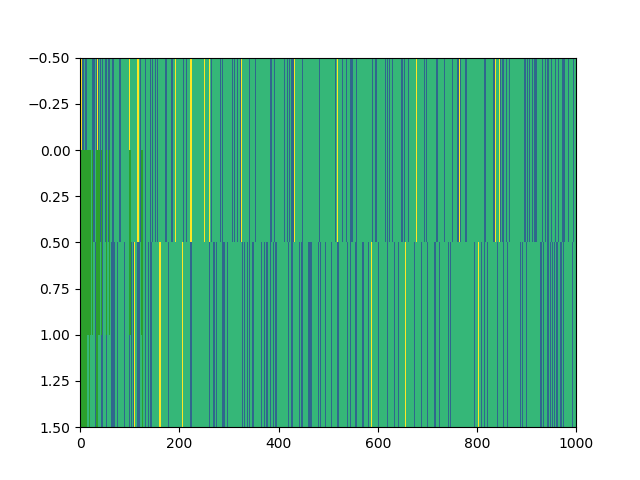

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.imshow(wrapper_1.residual_buffer, aspect='auto')

<IPython.core.display.Javascript object>


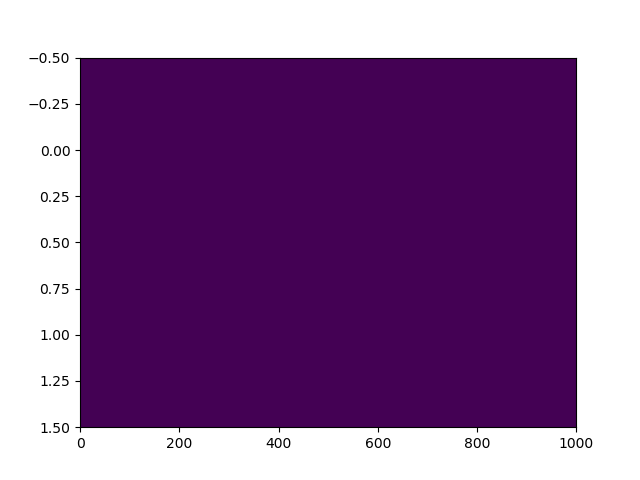

In [72]:
plt.imshow(wrapper_2.residual_buffer, aspect='auto')

In [23]:
plt.imshow(wrapper_3.residual_buffer, aspect='auto')

In [24]:
plt.imshow(wrapper_4.residual_buffer, aspect='auto')

From this, it seems that we could just cap the error at -1, 0, 1 as -2, 2 hardly occur for L = 2.

Let's have a long at L = 3...

In [25]:
# Try four VPUs
residual_array = np.zeros(shape=(3, 100, 4))
sum_err = np.zeros(shape=(3,100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(3, 1))
    mean = np.asarray([128, 128, 128]).reshape(-1, 1)
    vpu_1 = VPU_v2(3)
    vpu_2 = VPU_v2(3)
    vpu_3 = VPU_v2(3)
    vpu_4 = VPU_v2(3)
    wrapper_1 = VPUWrapper(vpu_1)
    wrapper_2 = VPUWrapper(vpu_2)
    wrapper_3 = VPUWrapper(vpu_3)
    wrapper_4 = VPUWrapper(vpu_4)
    for _ in range(0, 1000):
        # First VPU
        ternary_input = signal_pre_processor(data_in, mean)
        _, _, residual = wrapper_1.iterate(ternary_input)
        residual_array[:, i, 0] = residual.flatten()
        # Second VPU
        _, _, residual = wrapper_2.iterate(residual)
        residual_array[:, i, 1] = residual.flatten()
        _, _, residual = wrapper_3.iterate(residual)
        residual_array[:, i, 2] = residual.flatten()
        _, _, residual = wrapper_4.iterate(residual)
        residual_array[:, i, 3] = residual.flatten()
    est = mean+(wrapper_1.pred_estimate+wrapper_2.pred_estimate+wrapper_3.pred_estimate+wrapper_4.pred_estimate)*mean
    sum_err[:, i] = (data_in - est).flatten()

/home/ben/projects/var_processor/src/var_processor/power_iterator.py:35: RuntimeWarning: invalid value encountered in true_divide
  self.ev = self.ev / np.linalg.norm(self.ev)
/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/home/ben/projects/var_processor/src/tests/vpu_wrapper.py:20: RuntimeWarning: invalid value encountered in greater
  binary_values = np.where(np.abs(array) > rand_vals, 1, 0)


In [26]:
sum_err.astype(np.int8)

array([[ -19,  -27,   27,  -21,    5,    0,   27,  -64,   73,   34,  -29,
           3,   70,   48,   -7,   22,   30,   -1,   56,   75,   18,   14,
          11,  -39,   16,    0,   30,   -6,  -26,  -56,  -42,   34,   -8,
          20,   63,    6,   17,   -6,   79,   50,   12,  -46,   91,   11,
         -22,   46, -127,  -22,   47,  -22,  -59,    7,   -2,  -19,    5,
         -71,   25,  -22,   84,  -94,    9,   -1,  -77,    7,    1,    7,
          -1,   61,   -7,  -94,    2,   25,   13, -116,  -20,  -42,   88,
           8,   -8,  -13, -107,  -31,   57,  -18,  -14,   -9,   96,  -19,
         -54,  -20,   12,    5,  -42,    5,  -83,    5,   -4,   60,   63,
          -6],
       [ -35, -104,  -61,  119,  -20,    0,  -57,  114,   14,   39,  -17,
          11,  -39,  -19,  -74,   -1,  -24,    0,  -91,  -19,   22,  -81,
          -8,   80,  123,    0, -121,   -4,   22,   51,  -67,   32, -102,
         -27,  -39,    6,   34,    6,  -51,   61,   -7,   89,    9,  -10,
         -36,  -23,   2

In [27]:
plt.imshow(wrapper_1.residual_buffer, aspect='auto')

In [28]:
plt.imshow(wrapper_2.residual_buffer, aspect='auto')

This has a lot of error as compared to the above - is there something going wrong here?

In [29]:
wrapper_2.vpu.pi.eigenvector

array([[-0.13044746],
       [ 0.99053814],
       [ 0.04263402]])

In [30]:
wrapper_2.vpu.pi.eigenvector*(np.sqrt(3)/3)

array([[-0.07531388],
       [ 0.57188746],
       [ 0.02461476]])

In [31]:
wrapper_2.vpu.cu.mean

array([[-0.186],
       [ 0.547],
       [-0.959]])

**Ah - we have a non-zero mean - does our method only work when we constantly adjust to zero mean?**

In [32]:
wrapper_2.vpu.cu.mean

array([[-0.186],
       [ 0.547],
       [-0.959]])

In [33]:
plt.imshow(wrapper_3.residual_buffer, aspect='auto')

In [34]:
plt.imshow(wrapper_4.residual_buffer, aspect='auto')

# Just R Scaling

If we just scale R but don't PBT we should not have any signal loss. Let's test this.

In [35]:
class VPU_scale_r(VPU):
    """Let's update our functions modularly."""
    
    def __init__(self, size):
        """Adapted Init."""
        super(VPU_scale_r, self).__init__(size)
        # Calculate scale factor here to save time later
        self.scale_forward = np.sqrt(self.size)/self.size
        self.scale_backward = self.size/np.sqrt(self.size)
    
    def r_forward_processing(self, r_forward):
        """Scale r to -1 to 1 and PBT."""
        # Scale to ternary
        scaled_r = r_forward*self.scale_forward
        return scaled_r
    
    def r_backward_processing(self, r_backward):
        """Rescale r to -L/sqrt(L) to L/sqrt(L) and PBT."""
        # Scale to ternary
        scaled_r = r_backward*self.scale_backward
        return scaled_r
        

In [71]:
# Initialise two VPUs and wrappers
data_in = np.random.randint(255, size=(2, 1))
mean = np.asarray([128, 128]).reshape(-1, 1)
vpu_1 = VPU_scale_r(2)
vpu_2 = VPU_scale_r(2)
wrapper_1 = VPUWrapper(vpu_1)
wrapper_2 = VPUWrapper(vpu_2)
for _ in range(0, 1000):
    # First VPU
    ternary_input = signal_pre_processor(data_in, mean)
    _, _, residual = wrapper_1.iterate(ternary_input)
    # Second VPU
    _ = wrapper_2.iterate(residual)
est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)
print(data_in, est)

[[136]
 [129]] [[136.064]
 [128.896]]


Yes - this is still close enough.

In [37]:
# Look at error sum
sum_err = np.zeros(shape=(2,100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(2, 1))
    mean = np.asarray([128, 128]).reshape(-1, 1)
    vpu_1 = VPU_v2(2)
    vpu_2 = VPU_v2(2)
    wrapper_1 = VPUWrapper(vpu_1)
    wrapper_2 = VPUWrapper(vpu_2)
    for _ in range(0, 1000):
        # First VPU
        ternary_input = signal_pre_processor(data_in, mean)
        _, _, residual = wrapper_1.iterate(ternary_input)
        # Second VPU
        _ = wrapper_2.iterate(residual)
    est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)
    sum_err[:, i] = (data_in - est).flatten()
MSE = np.abs(sum_err.astype(np.int8)).mean(axis=1); MSE

array([25.42, 28.06])

In [38]:
sum_err.astype(np.int8).flatten()

array([  -5,   42,    9, -127,    6,   -7,   35,   13,   -6,  -11,  -10,
        -36,  -10,  -19,  -28,   20,   32,  122,    5,   -3,   34,   10,
          0,    8,   32,   -9,   36,  -26,   13,    3,  -57,    3,    7,
         53,  -17,   14,  -23,   10,  -12,   12,  -50,  -14, -115,  110,
         58,   38,   10,    6,   18, -104,  101,   32,   98,   -8,  -11,
         -6,   -6,   18,   25,  -41,   17,   18, -107,   35,   52,   -3,
          3,   -2,  -12,    2,  -13,  -28,   15,    0,    0,  -13,    0,
         13,   -5,    0,   12,    8,  -10,  -14,    4,  -16,   17,    8,
          2,  -35,   25,   57, -124,    3,    5,    4,    8,  -17,   21,
        -20,    4,  -53,  -11,    6,   17,  -16,   25,   -5,    5,   24,
         15,   -6,   -6,  104,   15,   34,   31,   15,  -20,    1,  -41,
        -12,  123,   19,  -15,  -23,  -28,   12,    6,  -17,  -52,   -6,
        -30,  -47,   29,  -12,  -31,  -10,   -9,  -18, -124,   -1,    1,
         -3,  -74,  -34,    3,  -19,    4,  -12,   

In [39]:
flattened = wrapper_1.residual_buffer.flatten()
results = plt.hist(flattened, bins=np.arange(-1.5, 2.5, 0.5), align='left')
plt.show()

In [40]:
flattened = wrapper_2.residual_buffer.flatten()
results = plt.hist(flattened, bins=np.arange(-1.5, 2.5, 0.5), align='left')
plt.show()

<IPython.core.display.Javascript object>


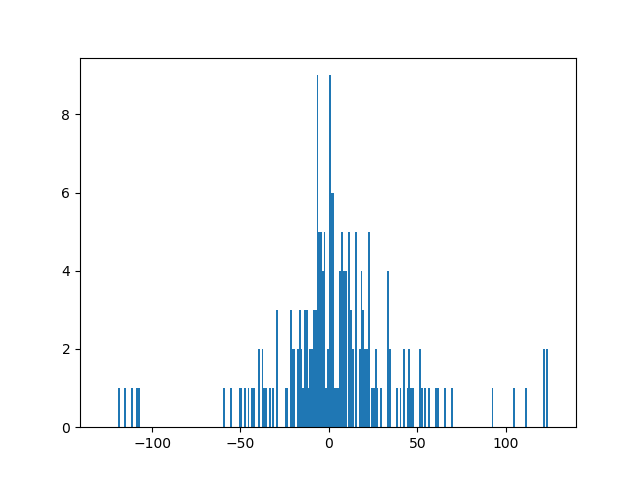

In [65]:
flattened = sum_err.astype(np.int8).flatten()
fig = plt.figure()
results = plt.hist(flattened, bins=np.arange(-128, 128))
plt.show()

In [42]:
wrapper_1.vpu.pi.eigenvector

array([[ 0.96490158],
       [-0.26261177]])

In [43]:
plt.imshow(wrapper_1.residual_buffer, aspect='auto')

In [44]:
plt.imshow(wrapper_2.residual_buffer, aspect='auto')

In [45]:
# Try three VPUs
residual_array = np.zeros(shape=(3, 100, 3))
sum_err = np.zeros(shape=(3,100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(3, 1))
    mean = np.asarray([128, 128, 128]).reshape(-1, 1)
    vpu_1 = VPU_scale_r(3)
    vpu_2 = VPU_scale_r(3)
    vpu_3 = VPU_scale_r(3)
    wrapper_1 = VPUWrapper(vpu_1)
    wrapper_2 = VPUWrapper(vpu_2)
    wrapper_3 = VPUWrapper(vpu_3)
    for _ in range(0, 1000):
        # First VPU
        ternary_input = signal_pre_processor(data_in, mean)
        _, _, residual = wrapper_1.iterate(ternary_input)
        residual_array[:, i, 0] = residual.flatten()
        # Second VPU
        _, _, residual = wrapper_2.iterate(residual)
        residual_array[:, i, 1] = residual.flatten()
        _, _, residual = wrapper_3.iterate(residual)
        residual_array[:, i, 2] = residual.flatten()     
    est = mean+(wrapper_1.pred_estimate+wrapper_2.pred_estimate+wrapper_3.pred_estimate)*mean
    sum_err[:, i] = (data_in - est).flatten()
MSE = np.abs(sum_err.astype(np.int8)).mean(axis=1); MSE

array([15.27, 20.74, 20.08])

In [46]:
# Try four VPUs
residual_array = np.zeros(shape=(3, 100, 4))
sum_err = np.zeros(shape=(3,100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(3, 1))
    mean = np.asarray([128, 128, 128]).reshape(-1, 1)
    vpu_1 = VPU_scale_r(3)
    vpu_2 = VPU_scale_r(3)
    vpu_3 = VPU_scale_r(3)
    vpu_4 = VPU_scale_r(3)
    wrapper_1 = VPUWrapper(vpu_1)
    wrapper_2 = VPUWrapper(vpu_2)
    wrapper_3 = VPUWrapper(vpu_3)
    wrapper_4 = VPUWrapper(vpu_4)
    for _ in range(0, 1000):
        # First VPU
        ternary_input = signal_pre_processor(data_in, mean)
        _, _, residual = wrapper_1.iterate(ternary_input)
        residual_array[:, i, 0] = residual.flatten()
        # Second VPU
        _, _, residual = wrapper_2.iterate(residual)
        residual_array[:, i, 1] = residual.flatten()
        _, _, residual = wrapper_3.iterate(residual)
        residual_array[:, i, 2] = residual.flatten()
        _, _, residual = wrapper_4.iterate(residual)
        residual_array[:, i, 3] = residual.flatten()
    est = mean+(wrapper_1.pred_estimate+wrapper_2.pred_estimate+wrapper_3.pred_estimate+wrapper_4.pred_estimate)*mean
    sum_err[:, i] = (data_in - est).flatten()
MSE = np.abs(sum_err.astype(np.int8)).mean(axis=1); MSE

array([ 9.43,  9.4 , 10.65])

In [47]:
sum_err.astype(np.int8)

array([[   6,    0,    7,    3,   -1,   -4,    5,    1,   77,    1,   -6,
           1,   -4,   -9,  -24,    2,    2,   12,   33,   -3,  -28,   -2,
          -8,   -3,    2,    3,    4,    2, -125,    3,   -3,    5,    1,
           0,   -9,    4,   16,   32,    2,    0,   -5,   30,   -3,    0,
           7,    1,   -5,    0,    1,   -6,  -24,   -7,   -3,   -1,    0,
          13,   11,    1,    0,    7,  -18,    0,   -2,  -23,    0,    0,
          -2,  -16,    4,    0,    1,    3,   -8,   -8,    0,    5,    5,
           4,   -2,    1,    6,   -7,    0,    5,    1,  -78,   -1,   -1,
         -11,    0,   -3, -100,    1,   -4,    0,   28,    6,    0,   -5,
           6],
       [   6,    0,    1,    1,   -8,    3,    0,   -4,   25,   -9,  -10,
          -5,  -11,   24,  -20,   -1,    0,    0,   13,    2,   27,   -4,
          -1,   -1,    2,   -2,    0,    0,    2,    7,   -4,   -3,    0,
          -2,    6,    4,   10,    0,    4,    0,   -3,  -72,   -2,    0,
         -25,    0,   -

In [48]:
MSE = np.abs(sum_err.astype(np.int8)).mean(axis=1); MSE

array([ 9.43,  9.4 , 10.65])

<IPython.core.display.Javascript object>


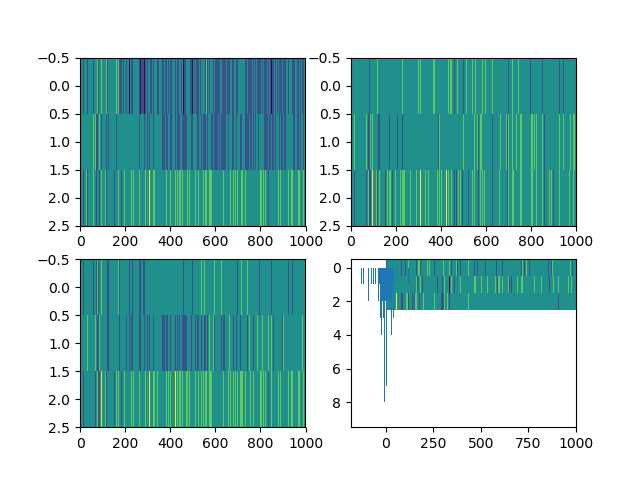

In [49]:
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(wrapper_1.residual_buffer, aspect='auto')
axes[1,0].imshow(wrapper_2.residual_buffer, aspect='auto')
axes[0,1].imshow(wrapper_3.residual_buffer, aspect='auto')
axes[1,1].imshow(wrapper_4.residual_buffer, aspect='auto')

In [50]:
np.set_printoptions(precision=3, suppress=True)
wrapper_1.r_buffer

array([[-0.158, -0.158,  0.816,  0.734, -0.247,  0.131,  0.   ,  0.768,
         0.401,  0.   ,  0.121,  0.   ,  0.   ,  0.693,  0.256,  0.351,
         0.772,  0.   ,  0.59 ,  0.   ,  0.418,  0.784,  0.414,  0.584,
         0.794,  0.   ,  0.956,  0.607,  0.188,  0.792,  0.808,  0.4  ,
         0.47 ,  0.391,  0.485,  0.431,  0.448,  0.   ,  0.807,  0.812,
         0.433,  0.378,  0.813,  0.447,  0.356,  0.347,  0.   ,  0.   ,
         0.   ,  0.   ,  0.813,  0.4  ,  0.   ,  0.387,  0.505,  0.367,
         0.445,  0.054,  0.462,  0.505,  0.002,  0.482,  0.803,  0.   ,
         0.477,  0.   ,  0.483,  0.04 ,  0.494,  0.836,  0.486,  0.   ,
         0.   ,  0.793,  0.8  ,  0.527,  0.806,  0.351,  0.349,  0.461,
         0.464,  0.468,  0.473,  0.   ,  0.868,  0.799,  0.459,  0.899,
         0.559,  0.436,  0.   ,  0.792,  0.798,  0.924,  0.797,  0.525,
         0.404,  0.543,  0.375,  0.794,  0.107,  0.368,  0.365,  0.361,
         0.   ,  0.804,  0.441,  0.897,  0.   ,  0.   ,  0.   , 

# Zero Mean VPU

Let's repeat the above but using the zero mean VPU.

In [51]:
from src.var_processor.vpu import VPUZeroMean

class VPU_scale_r(VPUZeroMean):
    """Let's update our functions modularly."""
    
    def __init__(self, size):
        """Adapted Init."""
        super(VPU_scale_r, self).__init__(size)
        # Calculate scale factor here to save time later
        self.scale_forward = np.sqrt(self.size)/self.size
        self.scale_backward = self.size/np.sqrt(self.size)
    
    def r_forward_processing(self, r_forward):
        """Scale r to -1 to 1 and PBT."""
        # Scale to ternary
        scaled_r = r_forward*self.scale_forward
        return scaled_r
    
    def r_backward_processing(self, r_backward):
        """Rescale r to -L/sqrt(L) to L/sqrt(L) and PBT."""
        # Scale to ternary
        scaled_r = r_backward*self.scale_backward
        return scaled_r

In [52]:
# Initialise two VPUs and wrappers
data_in = np.random.randint(255, size=(2, 1))
mean = np.asarray([128, 128]).reshape(-1, 1)
vpu_1 = VPU_scale_r(2)
vpu_2 = VPU_scale_r(2)
wrapper_1 = VPUWrapper(vpu_1)
wrapper_2 = VPUWrapper(vpu_2)
for _ in range(0, 1000):
    # First VPU
    ternary_input = signal_pre_processor(data_in, mean)
    _, _, residual = wrapper_1.iterate(ternary_input)
    # Second VPU
    _ = wrapper_2.iterate(residual)
est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)
print(data_in, est)

[[144]
 [ 94]] [[141.658]
 [ 95.304]]


In [74]:
# Try three VPUs
residual_array = np.zeros(shape=(3, 100, 3))
sum_err = np.zeros(shape=(3, 100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(3, 1))
    mean = np.asarray([128, 128, 128]).reshape(-1, 1)
    vpu_1 = VPU_scale_r(3)
    vpu_2 = VPU_scale_r(3)
    vpu_3 = VPU_scale_r(3)
    wrapper_1 = VPUWrapper(vpu_1)
    wrapper_2 = VPUWrapper(vpu_2)
    wrapper_3 = VPUWrapper(vpu_3)
    for _ in range(0, 1000):
        # First VPU
        ternary_input = signal_pre_processor(data_in, mean)
        _, _, residual = wrapper_1.iterate(ternary_input)
        residual_array[:, i, 0] = residual.flatten()
        # Second VPU
        _, _, residual = wrapper_2.iterate(residual)
        residual_array[:, i, 1] = residual.flatten()
        _, _, residual = wrapper_3.iterate(residual)
        residual_array[:, i, 2] = residual.flatten()
    est = mean+(wrapper_1.pred_estimate+wrapper_2.pred_estimate+wrapper_3.pred_estimate)*mean
    sum_err[:, i] = (data_in - est).flatten()

In [75]:
MSE = np.abs(sum_err.astype(np.int8)).mean(axis=1); MSE

array([4.87, 4.87, 5.15])

<IPython.core.display.Javascript object>


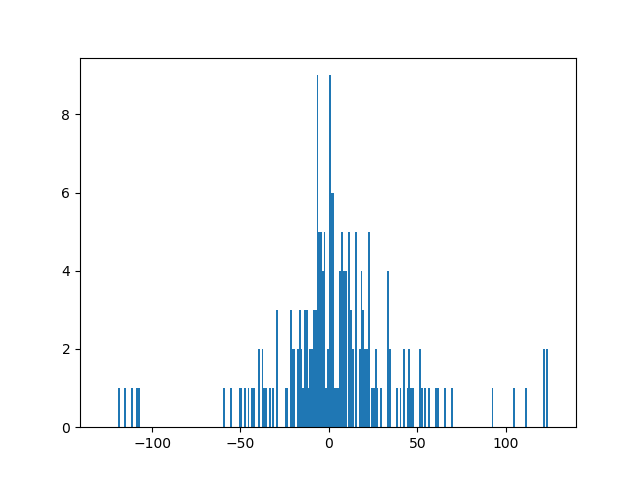

In [73]:
flattened = sum_err.astype(np.int8).flatten()
results = plt.hist(flattened, bins=np.arange(-128, 128))
plt.show()

Yes - so we are kind of okay if we have scaled R.

In [76]:
wrapper_1.r_buffer

array([[0.577, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.577,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.58 , 0.003, 0.   , 0.   , 0.003, 0.   , 0.577,
        0.   , 0.577, 0.   , 0.   , 0.   , 0.   , 0.003, 0.   , 0.   ,
        0.   , 0.003, 0.577, 0.003, 0.003, 0.577, 0.   , 0.   , 0.577,
        0.   , 0.003, 0.581, 0.   , 0.   , 0.003, 0.577, 0.   , 0.   ,
        0.003, 0.   , 0.   , 0.   , 0.   , 0.003, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.578,
        0.   , 0.   , 0.001, 0.   , 0.003, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.003, 0.   , 0.   , 0.577, 0.001, 0.   , 0.   , 0.   , 0.   ,
        0.577, 0.003, 0.   , 0.577, 0.003, 0.003, 0.577, 0.003, 0.004,
        0.581, 0.581, 0.   , 0.577, 0.   , 0.581, 0.578, 0.   , 0.577,
        0.   , 0.004, 0.   , 0.   , 0.   , 0.577, 0.578, 0.   , 0.   ,
      

In [77]:
wrapper_2.r_buffer

array([[ 0.   ,  0.   ,  0.   ,  0.   , -0.816,  0.   ,  0.   , -0.816,
         0.   ,  0.   , -0.424,  0.   ,  0.   , -0.402,  0.   ,  0.   ,
        -0.421, -0.401,  0.   , -0.407, -0.415, -0.419,  0.   ,  0.   ,
        -0.422,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   , -0.424,  0.   ,  0.   ,  0.   , -0.425,  0.   , -0.426,
        -0.427,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.428, -0.429,
         0.   ,  0.   , -0.43 ,  0.   ,  0.   ,  0.   , -0.431,  0.   ,
         0.   ,  0.   ,  0.   , -0.431,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.384,
         0.   ,  0.   , -0.385,  0.   , -0.431,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   , -0.385,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   , -0.431,  0.   ,  0.   ,  0.   , -0.385,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   , -0.431,  0.   ,  0.   , -0.431,
        -0.431,  0.   , -0.431, -0.815, -0.431, -0.432,  0.   , 

So if we have to clamp but are reconstructing over time...

One issue is that we haven't got a static r - so 0.433 leads to r 43% of the time. If we overshoot some of the time we want to undershoot other times to balance out.

In [80]:
wrapper_1.pred_estimate

array([[ 0.132],
       [-0.   ],
       [ 0.001]])

In [78]:
wrappers = np.asarray([wrapper_1.pred_estimate, wrapper_2.pred_estimate, wrapper_3.pred_estimate])
wrappers.shape

(3, 3, 1)

In [79]:
wrappers

array([[[ 0.132],
        [-0.   ],
        [ 0.001]],

       [[-0.   ],
        [-0.137],
        [ 0.154]],

       [[-0.   ],
        [ 0.055],
        [ 0.045]]])

In [83]:
wrappers.sum(axis=0)

array([[ 0.132],
       [-0.082],
       [ 0.2  ]])

In [84]:
# Try three VPUs with L = 4
size = 4
residual_array = np.zeros(shape=(size, 100, size))
sum_err = np.zeros(shape=(size, 100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(size, 1))
    mean = np.asarray([128]*size).reshape(-1, 1)
    vpus = [VPU_scale_r(size) for _ in range(0, size)]
    wrappers = [VPUWrapper(vpu) for vpu in vpus]
    for _ in range(0, 1000):
        # First VPU
        input_signal = signal_pre_processor(data_in, mean)
        for w, wrapper in enumerate(wrappers):
            _, _, residual = wrapper.iterate(input_signal)
            residual_array[:, i, w] = residual.flatten()
            input_signal = residual
    pred_sum = 0
    for wrapper in wrappers:
        pred_sum
    pred_estimate_sum = np.asarray([wrap.pred_estimate for wrap in wrappers]).sum(axis=0)
    scale_factor = np.minimum(mean, 255-mean)
    est = mean+pred_estimate_sum*scale_factor
    sum_err[:, i] = (data_in - est).flatten()
MSE = np.abs(sum_err.astype(np.int8)).mean(axis=1); MSE

array([5.32, 4.98, 5.18, 5.09])

In [89]:
sum_err.astype(np.int8)

array([[  0,  -1,  17,   0,   3,   9,  -4,   6,  -1,   9,  -7,   1,   0,
         -1,   0,   0,  -6,   0,   5,   8,   0,   8,   2,  -2,   0,  10,
          0,  -4,  11,  -8,   0,  -1,   5,  -5,  10,  -2,  12,  -1,   5,
          4,  -2,  -4,  12,   1,   0,  -1,   0,   7,  -1,   5,  -2,  -8,
         -2,  14,   5,   3, -19,   4,  -8,   0,  -1,   9,   0,   1, -13,
          1,   1,  -8,  18,   4, -14,  33,   1,  -3,  -4,   6,   8,   0,
         10,  -5,   0,   1,  -5,   3,  -5,  -2,   6, -13,  -6, -20,  32,
         -1,  -4,  14,   0,   0,  10,   0,  -2,   2],
       [ -4,   2,  14,   1,   3,  -1,   7, -10,  -4,  12,   6,   0,  12,
         -6,   0,   1,   6,  -3, -11,  -7,  -5,  10,  13,   1,   0,   0,
         -2,   4,  -4,   0,  -1,   2,   1,   1,   1,   0, -15,   3,  -3,
        -18,   0,   0,   0,  -3,  -9,  11,   0,  -1,   3,   2,  -1,  -2,
         15,  -1,  12,  -6,  24,   5,   1,   2, -11,  14,   3,  -8,  -2,
          0,   0,  17,   1,  -2,   5,  31,   3,  -3,   1,   5, -11,   

<IPython.core.display.Javascript object>


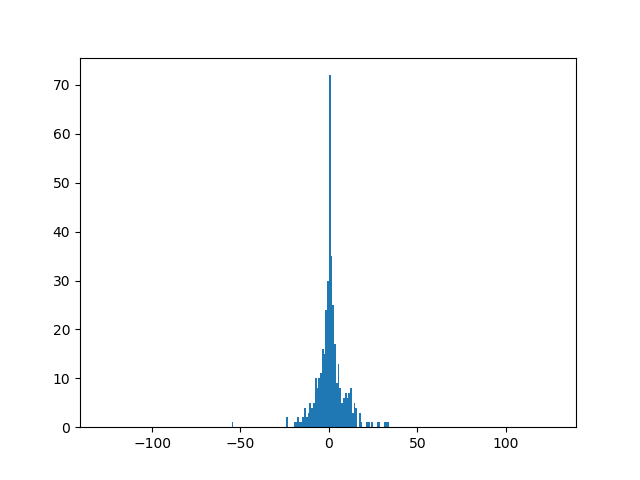

In [90]:
flattened = sum_err.astype(np.int8).flatten()
results = plt.hist(flattened, bins=np.arange(-128, 128))
plt.show()

The same distribution as the image pyramid residuals. Appears more distinctive for 4 (but maybe as just more error values).

In [95]:
wrappers[3].r_buffer

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.707,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.378,  0.   ,  0.   ,  0.   ,  0.   , -0.392,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.316,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        -0.389,  0.   ,  0.   ,  0.316,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.389,  0.   ,  0.   ,  0.   ,  0.   , 

In [100]:
print(wrappers[3].vpu.pi.eigenvector, wrappers[3].vpu.pi.eigenvector*(np.sqrt(4)/4))

[[ 0.776]
 [-0.63 ]
 [ 0.   ]
 [ 0.   ]] [[ 0.388]
 [-0.315]
 [ 0.   ]
 [ 0.   ]]


In [102]:
print([w.vpu.pi.feature for w in wrappers])

[array([[ 0.345],
       [ 0.347],
       [-0.101],
       [ 0.011]]), array([[0.001],
       [0.001],
       [0.5  ],
       [0.   ]]), array([[-0.003],
       [ 0.003],
       [ 0.   ],
       [ 0.5  ]]), array([[ 0.388],
       [-0.315],
       [ 0.   ],
       [ 0.   ]])]


## L = 4 with Just Ternary Outputs

**This is the useful code.**

In [103]:
class VPU_v2_ZM(VPUZeroMean):
    """Let's update our functions modularly."""
    
    def __init__(self, size):
        """Adapted Init."""
        super(VPU_v2_ZM, self).__init__(size)
        # Calculate scale factor here to save time later
        self.scale_forward = np.sqrt(self.size)/self.size
        self.scale_backward = self.size/np.sqrt(self.size)
    
    def r_forward_processing(self, r_forward):
        """Scale r to -1 to 1 and PBT."""
        # Scale to ternary
        scaled_r = r_forward*self.scale_forward
        sign = np.sign(scaled_r)
        rand_val = np.random.uniform()
        binary_values = np.where(np.abs(scaled_r) > rand_val, 1, 0)
        # resign and convert to 8-bit
        binary_values = sign*binary_values.astype(np.uint8)
        return binary_values
    
    def r_backward_processing(self, r_backward):
        """Rescale r to -L/sqrt(L) to L/sqrt(L) and PBT."""
        # Scale to ternary
        scaled_r = r_backward*self.scale_backward
        return scaled_r
        
    def pred_input_processing(self, pred_inputs):
        """Apply PBT to get outputs in range -1, 0, 1."""
        sign = np.sign(pred_inputs)
        rand_val = np.random.uniform()
        binary_values = np.where(np.abs(pred_inputs) > rand_val, 1, 0)
        # resign and convert to 8-bit
        binary_values = sign*binary_values.astype(np.uint8)
        return binary_values

In [115]:
# Try four VPUs with L = 4
size = 4
residual_array = np.zeros(shape=(size, 100, size))
sum_err = np.zeros(shape=(size, 100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(size, 1))
    mean = np.asarray([128]*size).reshape(-1, 1)
    vpus = [VPU_v2_ZM(size) for _ in range(0, size)]
    wrappers = [VPUWrapper(vpu) for vpu in vpus]
    for _ in range(0, 1000):
        # First VPU
        input_signal = signal_pre_processor(data_in, mean)
        for w, wrapper in enumerate(wrappers):
            _, _, residual = wrapper.iterate(input_signal)
            residual_array[:, i, w] = residual.flatten()
            input_signal = residual
    pred_sum = 0
    for wrapper in wrappers:
        pred_sum
    pred_estimate_sum = np.asarray([wrap.pred_estimate for wrap in wrappers]).sum(axis=0)
    scale_factor = np.minimum(mean, 255-mean)
    est = mean+pred_estimate_sum*scale_factor
    sum_err[:, i] = (data_in - est).flatten()
    print(f"Data: {data_in} - Estimate: {est}\n")
MSE = np.abs(sum_err.astype(np.int8)).mean(axis=1); MSE

Data: [[137]
 [ 11]
 [ 77]
 [147]] - Estimate: [[129.016]
 [ 21.574]
 [105.267]
 [134.35 ]]

Data: [[ 82]
 [230]
 [136]
 [212]] - Estimate: [[ 82.28 ]
 [202.168]
 [128.127]
 [198.993]]

Data: [[ 49]
 [ 27]
 [116]
 [ 21]] - Estimate: [[55.229]
 [50.022]
 [76.438]
 [52.435]]

Data: [[147]
 [252]
 [161]
 [ 94]] - Estimate: [[189.849]
 [225.536]
 [132.826]
 [ 70.977]]

Data: [[160]
 [ 38]
 [ 18]
 [ 30]] - Estimate: [[164.957]
 [ 43.164]
 [ 21.955]
 [ 40.243]]

Data: [[ 72]
 [211]
 [218]
 [234]] - Estimate: [[ 80.756]
 [215.503]
 [221.472]
 [223.885]]

Data: [[144]
 [105]
 [ 75]
 [234]] - Estimate: [[129.651]
 [126.222]
 [120.888]
 [227.568]]

Data: [[ 70]
 [201]
 [148]
 [ 92]] - Estimate: [[ 90.408]
 [171.561]
 [155.686]
 [ 95.996]]

Data: [[  7]
 [ 40]
 [139]
 [ 88]] - Estimate: [[ 24.495]
 [ 45.45 ]
 [126.349]
 [ 85.074]]

Data: [[ 14]
 [206]
 [ 82]
 [ 49]] - Estimate: [[ 20.939]
 [213.09 ]
 [ 82.661]
 [ 54.086]]

Data: [[ 74]
 [161]
 [126]
 [ 45]] - Estimate: [[ 86.725]
 [165.719]
 [127

/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


Data: [[179]
 [225]
 [134]
 [ 52]] - Estimate: [[nan]
 [nan]
 [nan]
 [nan]]

Data: [[ 94]
 [179]
 [ 31]
 [140]] - Estimate: [[117.967]
 [178.673]
 [ 33.131]
 [131.683]]

Data: [[ 46]
 [123]
 [ 41]
 [151]] - Estimate: [[nan]
 [nan]
 [nan]
 [nan]]

Data: [[138]
 [175]
 [ 28]
 [ 35]] - Estimate: [[172.577]
 [146.542]
 [ 61.706]
 [ 35.671]]

Data: [[250]
 [ 38]
 [ 33]
 [ 66]] - Estimate: [[232.14 ]
 [ 33.766]
 [ 44.942]
 [ 52.435]]

Data: [[ 22]
 [ 63]
 [ 79]
 [213]] - Estimate: [[ 24.114]
 [ 62.722]
 [ 81.391]
 [214.106]]

Data: [[188]
 [165]
 [107]
 [ 79]] - Estimate: [[178.165]
 [141.081]
 [ 86.471]
 [ 83.931]]

Data: [[207]
 [241]
 [199]
 [142]] - Estimate: [[206.486]
 [211.185]
 [173.72 ]
 [168.767]]

Data: [[ 62]
 [215]
 [206]
 [149]] - Estimate: [[ 55.229]
 [207.121]
 [204.708]
 [128.254]]

Data: [[ 79]
 [249]
 [228]
 [159]] - Estimate: [[ 81.645]
 [240.776]
 [226.933]
 [162.544]]

Data: [[120]
 [179]
 [ 98]
 [  8]] - Estimate: [[125.46 ]
 [201.533]
 [122.158]
 [ 23.098]]

Data: [[ 

array([11.2 , 11.52, 13.87, 13.04])

It doubles the error but we're still not too bad. In fact, this is surprisingly good.

In [116]:
sum_err.astype(np.int8)

array([[  7,   0,  -6, -42,  -4,  -8,  14, -20, -17,  -6, -12,  12, -15,
          4, -20,   1,   7,  -5,  24,   2, -32,   7,  -4, -17,  -3,  13,
        -39,   7,   9,   0, -23,   0, -34,  17,  -2,   9,   0,   6,  -2,
         -5,   2,   2,   5,  35,   0,   3,  -6,  -8,  16,  10,   9,   1,
         12,   0,  -8,  -4,  -6,   2,   9,  22, -22,   0, -21, -29,  13,
          7,  -7,   5,   0,  17,  -1,   0, -21, -17,  -3,  11,   8, -18,
         -9, -28,  30,  40,  -9,  12,  17,  -3,   3,  15, -24,  -1,   8,
         -7, -41,  -6,   6,  -1,   1,   7,  -5, -32],
       [-10,  27, -23,  26,  -5,  -4, -21,  29,  -5,  -7,  -4,  -4,  12,
          6,   3,   0, -36, -29,  -2,  -3, -11,  -1,   4,   4, -14,  -2,
          3,   1,   3,   0,   0,   0,  28,   4,   0,  23,  29,   7,   8,
        -22, -12,  -5, -25,  41, -10,   8,  16,  -3, -28,   2,   5, -22,
         -7,   0,  -6,  30,   3,  -1, -12, -28,   8,   6, -13,   1, -10,
         -1, -21, -27,  27,  -7,  16,  -3, -23, -13,  -7,   9,   8, -1

<IPython.core.display.Javascript object>


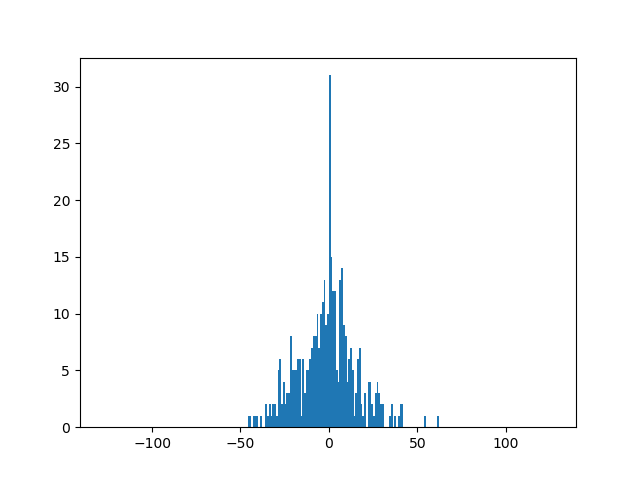

In [117]:
flattened = sum_err.astype(np.int8).flatten()
results = plt.hist(flattened, bins=np.arange(-128, 128))
plt.show()

<IPython.core.display.Javascript object>


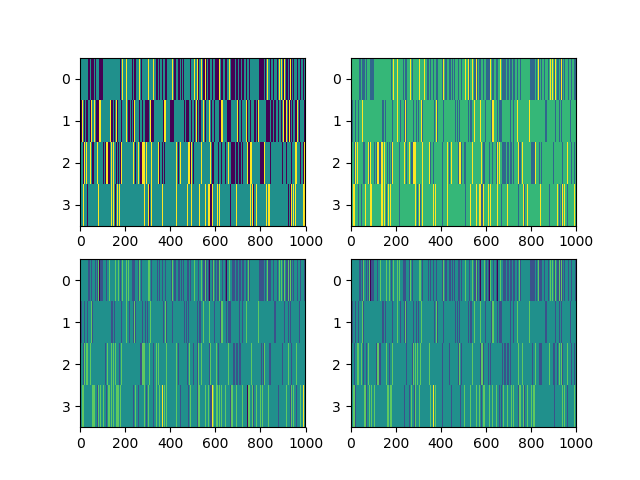

In [118]:
fig, axes = plt.subplots(size//2, size//2)
for plot, wrapper in zip(axes.ravel(), wrappers):
    plot.imshow(wrapper.residual_buffer, aspect='auto')
plt.show()

In [119]:
print(wrappers[0].r_buffer, wrappers[0].pred_buffer, sep="\n")

[[-1. -1. -1. -1. -0. -1. -1. -1. -1. -0. -0. -1. -1. -1. -1. -0. -1. -1.
  -1. -1.  0. -1. -1. -1. -1. -1. -1. -0. -1. -0. -0. -1. -0. -1. -1. -0.
  -1. -0. -0. -0. -0. -1. -0. -1. -0. -0. -1. -0. -1. -1. -0. -1. -1. -1.
  -1. -0. -1. -0. -0. -0. -1. -0. -1. -1. -0. -0. -1. -1. -0.  0. -0. -1.
  -1. -1.  0. -1. -1. -1. -1. -0. -1. -1.  0. -1. -0. -0. -0. -1. -0. -1.
  -0. -1. -1. -1. -1. -0. -1. -1.  0. -0. -1. -0. -1. -0.  0. -0. -0. -0.
  -1. -1. -0. -1. -0. -0. -0. -1. -1. -1. -0. -0. -0. -1. -0. -0. -1.  0.
  -0. -0. -0. -1. -0. -1. -0. -0. -0. -0. -1. -0. -1. -1. -1. -0. -0. -1.
  -0. -0. -1. -1. -1. -1. -0. -1. -1. -0. -0. -1. -1. -1.  0. -1. -0. -0.
  -1. -1. -1. -1. -0. -1. -0. -1. -0. -1. -1. -0. -1. -1. -0. -0. -1. -0.
  -1. -0. -1. -1. -1. -1. -1. -0. -1. -1. -1. -0.  0. -0. -1. -1. -1. -1.
  -0. -1. -0.  0. -0. -1. -1. -1. -0. -1. -1. -0. -1. -1. -1. -1. -1. -0.
  -1. -1. -1. -1. -0. -0. -1. -1. -1. -1. -1. -1. -0.  0. -0. -0. -0. -1.
  -1. -0. -1. -1. -0. -1. -1. -0.  0. 

Is it something about symmetry - errors cancelling out but only if there is some symmetry? Hence, working well for 4.

Further interesting that there are very few 2s. We could easily clamp without much effect.

## Variation

Let's try not scaling r going backward but just saturating.

In [113]:
class VPU_v2_1(VPUZeroMean):
    """Let's update our functions modularly."""
    
    def __init__(self, size):
        """Adapted Init."""
        super(VPU_v2_1, self).__init__(size)
        # Calculate scale factor here to save time later
        self.scale_forward = np.sqrt(self.size)/self.size
        self.scale_backward = self.size/np.sqrt(self.size)
    
    def r_forward_processing(self, r_forward):
        """Scale r to -1 to 1 and PBT."""
        # Scale to ternary
        scaled_r = r_forward*self.scale_forward
        sign = np.sign(scaled_r)
        rand_val = np.random.uniform()
        binary_values = np.where(np.abs(scaled_r) > rand_val, 1, 0)
        # resign and convert to 8-bit
        binary_values = sign*binary_values.astype(np.uint8)
        return binary_values
        
    def pred_input_processing(self, pred_inputs):
        """Apply PBT to get outputs in range -1, 0, 1."""
        sign = np.sign(pred_inputs)
        rand_val = np.random.uniform()
        binary_values = np.where(np.abs(pred_inputs) > rand_val, 1, 0)
        # resign and convert to 8-bit
        binary_values = sign*binary_values.astype(np.uint8)
        return binary_values

In [114]:
# Try four VPUs with L = 4
size = 4
residual_array = np.zeros(shape=(size, 100, size))
sum_err = np.zeros(shape=(size, 100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(size, 1))
    mean = np.asarray([128]*size).reshape(-1, 1)
    vpus = [VPU_v2_1(size) for _ in range(0, size)]
    wrappers = [VPUWrapper(vpu) for vpu in vpus]
    for _ in range(0, 1000):
        # First VPU
        input_signal = signal_pre_processor(data_in, mean)
        for w, wrapper in enumerate(wrappers):
            _, _, residual = wrapper.iterate(input_signal)
            residual_array[:, i, w] = residual.flatten()
            input_signal = residual
    pred_sum = 0
    for wrapper in wrappers:
        pred_sum
    pred_estimate_sum = np.asarray([wrap.pred_estimate for wrap in wrappers]).sum(axis=0)
    scale_factor = np.minimum(mean, 255-mean)
    est = mean+pred_estimate_sum*scale_factor
    sum_err[:, i] = (data_in - est).flatten()
    print(f"Data: {data_in} - Estimate: {est}\n")
MSE = np.abs(sum_err.astype(np.int8)).mean(axis=1); MSE

Data: [[161]
 [ 61]
 [ 36]
 [174]] - Estimate: [[152.257]
 [ 74.406]
 [ 47.228]
 [183.753]]

Data: [[206]
 [100]
 [242]
 [249]] - Estimate: [[204.708]
 [103.108]
 [230.489]
 [240.903]]

Data: [[196]
 [ 18]
 [118]
 [174]] - Estimate: [[185.658]
 [ 59.547]
 [125.714]
 [187.182]]

Data: [[106]
 [ 70]
 [171]
 [123]] - Estimate: [[127.746]
 [ 78.597]
 [180.324]
 [127.619]]

Data: [[149]
 [ 48]
 [223]
 [140]] - Estimate: [[131.556]
 [ 38.211]
 [199.12 ]
 [127.873]]

Data: [[206]
 [126]
 [110]
 [224]] - Estimate: [[168.005]
 [ 95.234]
 [127.238]
 [133.588]]

Data: [[145]
 [ 82]
 [ 30]
 [248]] - Estimate: [[129.524]
 [ 93.583]
 [ 58.404]
 [242.681]]

Data: [[ 76]
 [101]
 [167]
 [154]] - Estimate: [[ 73.898]
 [111.236]
 [138.668]
 [143.494]]

Data: [[192]
 [106]
 [254]
 [236]] - Estimate: [[167.497]
 [ 99.552]
 [244.459]
 [242.3  ]]

Data: [[208]
 [ 97]
 [ 32]
 [159]] - Estimate: [[191.754]
 [127.365]
 [ 59.42 ]
 [190.357]]

Data: [[193]
 [ 22]
 [123]
 [174]] - Estimate: [[196.834]
 [ 57.642]
 

Data: [[217]
 [150]
 [186]
 [141]] - Estimate: [[196.58 ]
 [141.335]
 [184.515]
 [130.794]]

Data: [[ 11]
 [198]
 [136]
 [244]] - Estimate: [[ 32.242]
 [182.356]
 [129.524]
 [250.174]]

Data: [[166]
 [163]
 [ 78]
 [252]] - Estimate: [[133.715]
 [165.846]
 [ 91.932]
 [219.313]]

Data: [[114]
 [213]
 [ 30]
 [187]] - Estimate: [[127.619]
 [208.772]
 [ 46.72 ]
 [195.31 ]]

Data: [[152]
 [210]
 [241]
 [ 43]] - Estimate: [[177.911]
 [191.246]
 [225.409]
 [ 73.898]]

Data: [[  9]
 [114]
 [174]
 [203]] - Estimate: [[ 25.638]
 [122.412]
 [172.323]
 [197.469]]

Data: [[251]
 [ 41]
 [117]
 [196]] - Estimate: [[227.949]
 [ 27.543]
 [123.936]
 [173.466]]

Data: [[171]
 [115]
 [209]
 [ 73]] - Estimate: [[169.275]
 [111.109]
 [182.229]
 [ 82.153]]

Data: [[223]
 [218]
 [200]
 [ 42]] - Estimate: [[215.63 ]
 [207.629]
 [187.436]
 [ 48.498]]

Data: [[247]
 [  5]
 [ 23]
 [ 70]] - Estimate: [[233.918]
 [ 22.336]
 [ 25.892]
 [ 69.072]]

Data: [[127]
 [ 53]
 [149]
 [215]] - Estimate: [[128.   ]
 [ 59.166]
 

array([18.92, 16.48, 14.4 , 15.6 ])

It is a bit higher. But is this just randomness?

In [57]:
# Initialise two VPUs and wrappers
data_in = np.random.randint(255, size=(2, 1))
mean = np.asarray([128, 128]).reshape(-1, 1)
vpu_1 = VPU_v2_1(2)
vpu_2 = VPU_v2_1(2)
wrapper_1 = VPUWrapper(vpu_1)
wrapper_2 = VPUWrapper(vpu_2)
for _ in range(0, 1000):
    # First VPU
    ternary_input = signal_pre_processor(data_in, mean)
    _, _, residual = wrapper_1.iterate(ternary_input)
    # Second VPU
    _ = wrapper_2.iterate(residual)
est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)
print(data_in, est)

[[49]
 [88]] [[ 78.848]
 [115.072]]


Similar - maybe worse.

In [58]:
# Look at error sum
sum_err = np.zeros(shape=(2,100))
for i in range(0, 100):
    # Initialise two VPUs and wrappers
    data_in = np.random.randint(255, size=(2, 1))
    mean = np.asarray([128, 128]).reshape(-1, 1)
    vpu_1 = VPU_v2_1(2)
    vpu_2 = VPU_v2_1(2)
    wrapper_1 = VPUWrapper(vpu_1)
    wrapper_2 = VPUWrapper(vpu_2)
    for _ in range(0, 1000):
        # First VPU
        ternary_input = signal_pre_processor(data_in, mean)
        _, _, residual = wrapper_1.iterate(ternary_input)
        # Second VPU
        _ = wrapper_2.iterate(residual)
    est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)
    sum_err[:, i] = (data_in - est).flatten()

In [59]:
# We can't use mean as have mix of +ve and -ve - if we take the MSE
MSE = np.abs(sum_err).mean(axis=1); MSE

array([22.674, 26.074])

In [60]:
np.abs(sum_err)

array([[ 60.592,  27.048, 109.144,  38.12 ,  22.208,   5.592,  18.144,
          9.656,  26.424,   5.368,   0.256,  10.696,   2.872,  24.352,
          3.632,  15.312,  18.008,   7.152,   6.04 ,  12.152,  13.696,
          8.176,   4.16 ,  11.504,  38.016,  56.304,   2.176, 119.168,
          9.256,   2.088, 112.504,   5.504,   5.432,  33.344,  51.904,
         14.736,  16.328, 121.184,   9.408,   0.016,  21.912,  30.816,
          0.184,  33.792,   5.64 ,  10.952,  24.296, 104.304,   9.416,
          7.592,   0.288,  40.984,   6.12 ,   6.824,   8.16 ,   3.536,
         15.176,   1.624,  20.472,  38.712,  56.984,   8.312,  17.16 ,
          3.28 ,   6.48 ,   3.536,   6.976,  32.6  ,   7.336,  14.312,
         11.176,  13.504,  54.352,   1.872,   7.296,  33.88 ,   2.432,
          9.248,   7.28 ,   7.504,  60.248,  22.728,  34.872,   6.432,
         13.488,  30.704,   4.24 ,   8.184,   7.632,   0.728,  36.336,
          4.8  ,  42.8  ,  46.216,  45.144,  50.288,  11.976,  43.056,
      

In [61]:
# We can't use mean as have mix of +ve and -ve - if we take the MSE
MSE = np.abs(np.nan_to_num(sum_err, 0)).mean(axis=1); MSE

array([22.674, 26.074])

Actually about the same. But we want to undo the scaling so then we get nice features?

In [62]:
255 - mean

array([[127],
       [127]])

In [64]:
np.minimum(mean, 255-mean)

array([[127],
       [127]])